# Basics

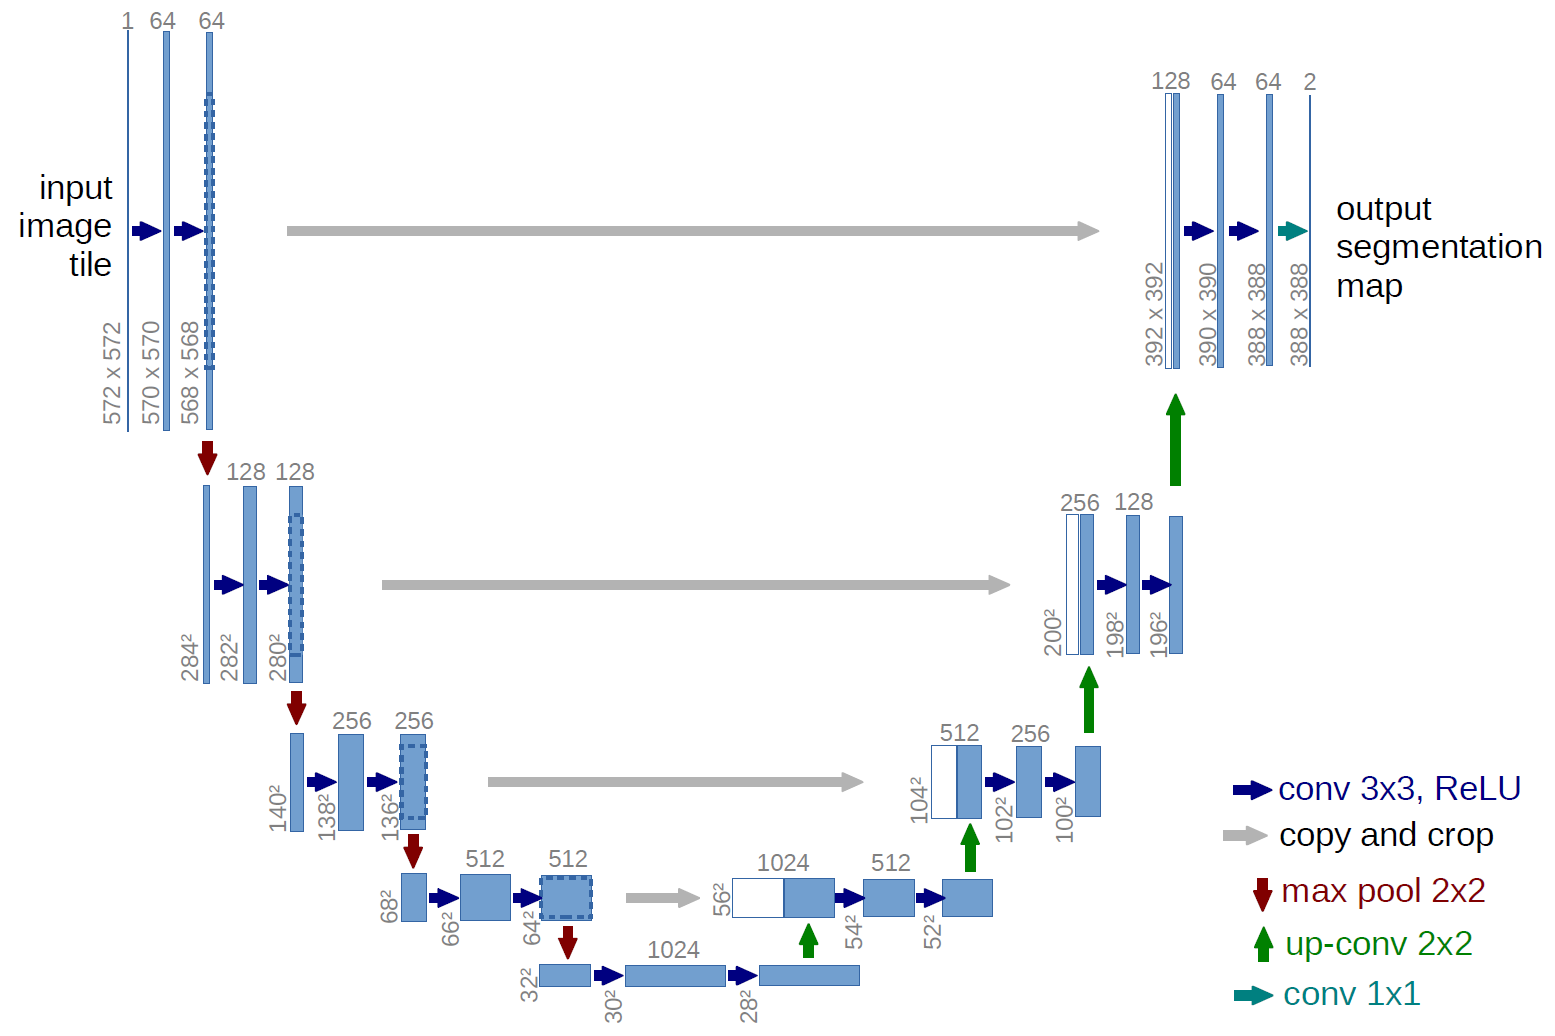

In [22]:
from IPython.display import Image

Image("https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png")

## Unet

In [23]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

In [24]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features = [64, 128, 256, 512]):
        super(Unet, self).__init__()

        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2, padding=1))
            self.ups.append(DoubleConv(in_channels = feature * 2, out_channels = feature))

        self.bottleneck = DoubleConv(in_channels= features[-1], out_channels = features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if skip_connection.shape != x.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
                concat = torch.concat([x, skip_connection], dim=1)
                x = self.ups[idx + 1](concat)

        return self.final_conv(x)

## Dataset

In [25]:
from torch.utils.data import  DataLoader
import numpy as np
from torch.utils.data import Dataset
import os
from PIL import Image

In [26]:
def get_loaders(train_img_dir, train_mask_dir, val_img_dir,val_mask_dir,
                train_transform, val_transform, batch_size, num_workers, pin_memory = True):

    train_dataset = CarvanaDataset(train_img_dir, train_mask_dir, train_transform)
    val_dataset = CarvanaDataset(val_img_dir, val_mask_dir, val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

    return train_loader, val_loader

In [27]:
class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", ".png"))

        image = np.array(Image.open(image_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L')) # Gray

        if self.transform is not None:
            transformation = self.transform(image = image, mask = mask)
            image = transformation['image']
            mask = transformation['mask']
            mask[mask == 255] = 1.

        return image, mask

## visualiztion

In [28]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [29]:
def save_predictions_as_img(loader, model, epoch_index, folder="saved_images/", DEVICE="cuda"):
    print("=> Saving Predictions")
    model.eval()
    for index, (x, y) in enumerate(loader):
        x = x.to(device=DEVICE)
        with torch.no_grad():
            predictions = torch.sigmoid(model(x))
            predictions = (predictions > 0.5).float()
        save_image(predictions, f"{folder}/pred_{epoch_index}_{index}.png")
        #torchvision.utils.save_image(y.unsqeeze(1), f"{folder}/{index}.png")
    model.train()

In [30]:
def plot_loss_acc(train_losses, val_acc, val_dice, num_epoch):
    plt.figure(figsize=(15, 5), dpi=400)

    plt.subplot(1, 3, 1)
    plt.plot(range(num_epoch), train_losses, label="Train Loss", color="blue")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(range(num_epoch), val_acc, label="Val Acc", color="green")
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.title('Acc Over Epochs In Val')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(range(num_epoch), val_dice, label="Val Dice", color="red")
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.title('Dice Over Epochs In Val')
    plt.legend()

    plt.tight_layout()
    plt.savefig('train_acc_dice_plot.png')
    print("Save Success")

## Train

In [31]:
import albumentations as A # augmented lib
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from tqdm import tqdm

import random

In [32]:
# Hyperparameters

LEARNING_RATE = 1e-4
BATCH_SIZE = 32
NUM_EPOCH = 10
NUM_WORKERS = 2
PIN_MEMORY = True

DEVICE = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

TRAIN_IMG_DIR = "./data/train_images"
TRAIN_MASK_DIR = "./data/train_masks"
VAL_IMG_DIR = "./data/val_images"
VAL_MASK_DIR = "./data/val_masks"

IMAGE_HEIGHT = 160
IMAGE_WIDTH = 240

train_loss = []
val_acc = []
val_dice = []

# set random seed
seed = random.randint(1, 100)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def trainer(loader, model, loss_fn, optimizer, scaler):
    loop = tqdm(loader)
    total_loss = 0.0
    for idx, (data, target) in enumerate(loop):
        data = data.to(DEVICE)
        target = target.unsqueeze(1).float().to(DEVICE)

        with torch.amp.autocast('cuda'):
            predict = model(data)
            loss = loss_fn(predict, target)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        loop.set_postfix(loss=loss.item())
    return total_loss / len(loader)

def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.unsqueeze(1).to(DEVICE)
            predictions = torch.sigmoid(model(x))
            predictions = (predictions > 0.5).float()
            num_correct += (predictions == y).sum()
            num_pixels += torch.numel(predictions)
            dice_score += (2 * (predictions * y).sum()
                           ) / (2 * (predictions * y).sum() + ((predictions * y) < 1).sum())

    accuracy = round(float(num_correct / num_pixels), 4)
    dice = round(float(dice_score / len(loader)), 4)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct / num_pixels * 100 :.2f}")
    print(f"Dice Score: {dice_score / len(loader)}")

    model.train()
    return accuracy, dice

train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Rotate(limit = 35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
        mean = [0.0, 0.0, 0.0],
        std = [1.0, 1.0, 1.0],
        max_pixel_value = 255.0,
    ),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
        mean = [0.0, 0.0, 0.0],
        std = [1.0, 1.0, 1.0],
        max_pixel_value = 255.0,
    ),
    ToTensorV2(),
])

train_loader, val_loader = get_loaders(TRAIN_IMG_DIR, TRAIN_MASK_DIR, VAL_IMG_DIR, VAL_MASK_DIR,
                                       train_transform, val_transform, BATCH_SIZE, NUM_WORKERS, PIN_MEMORY)

model = Unet(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.amp.GradScaler('cuda')

for epoch in range(NUM_EPOCH):
    print("Current Epoch: ", epoch)
    loss = trainer(train_loader, model, loss_fn, optimizer, scaler)
    train_loss.append(loss)

    accuracy, dice = check_accuracy(val_loader, model)
    val_acc.append(accuracy)
    val_dice.append(dice)
    
    if (epoch+1) % 10 == 0:
        save_predictions_as_img(val_loader, model, epoch_index=epoch+1, folder="saved_images/", DEVICE=DEVICE)

Current Epoch:  0


100%|██████████| 50/50 [00:16<00:00,  3.01it/s, loss=0.226]


Got 14754501/15360000 with acc 96.06
Dice Score: 0.29226604104042053
Current Epoch:  1


100%|██████████| 50/50 [00:16<00:00,  3.00it/s, loss=0.194]


Got 15144010/15360000 with acc 98.59
Dice Score: 0.33797717094421387
Current Epoch:  2


100%|██████████| 50/50 [00:16<00:00,  3.00it/s, loss=0.174]


Got 15087026/15360000 with acc 98.22
Dice Score: 0.3418215811252594
Current Epoch:  3


100%|██████████| 50/50 [00:16<00:00,  3.00it/s, loss=0.156]


Got 15134031/15360000 with acc 98.53
Dice Score: 0.3419456481933594
Current Epoch:  4


100%|██████████| 50/50 [00:16<00:00,  2.99it/s, loss=0.142]


Got 15177033/15360000 with acc 98.81
Dice Score: 0.3414769172668457
Current Epoch:  5


100%|██████████| 50/50 [00:16<00:00,  2.99it/s, loss=0.128]


Got 15218268/15360000 with acc 99.08
Dice Score: 0.34024688601493835
Current Epoch:  6


100%|██████████| 50/50 [00:16<00:00,  2.99it/s, loss=0.117]


Got 15227995/15360000 with acc 99.14
Dice Score: 0.3398934602737427
Current Epoch:  7


100%|██████████| 50/50 [00:16<00:00,  2.99it/s, loss=0.107]


Got 15237784/15360000 with acc 99.20
Dice Score: 0.33937448263168335
Current Epoch:  8


100%|██████████| 50/50 [00:16<00:00,  2.99it/s, loss=0.0984]


Got 15216054/15360000 with acc 99.06
Dice Score: 0.3395940363407135
Current Epoch:  9


100%|██████████| 50/50 [00:16<00:00,  2.99it/s, loss=0.0924]


Got 15210036/15360000 with acc 99.02
Dice Score: 0.3414981961250305
=> Saving Predictions


Save Success


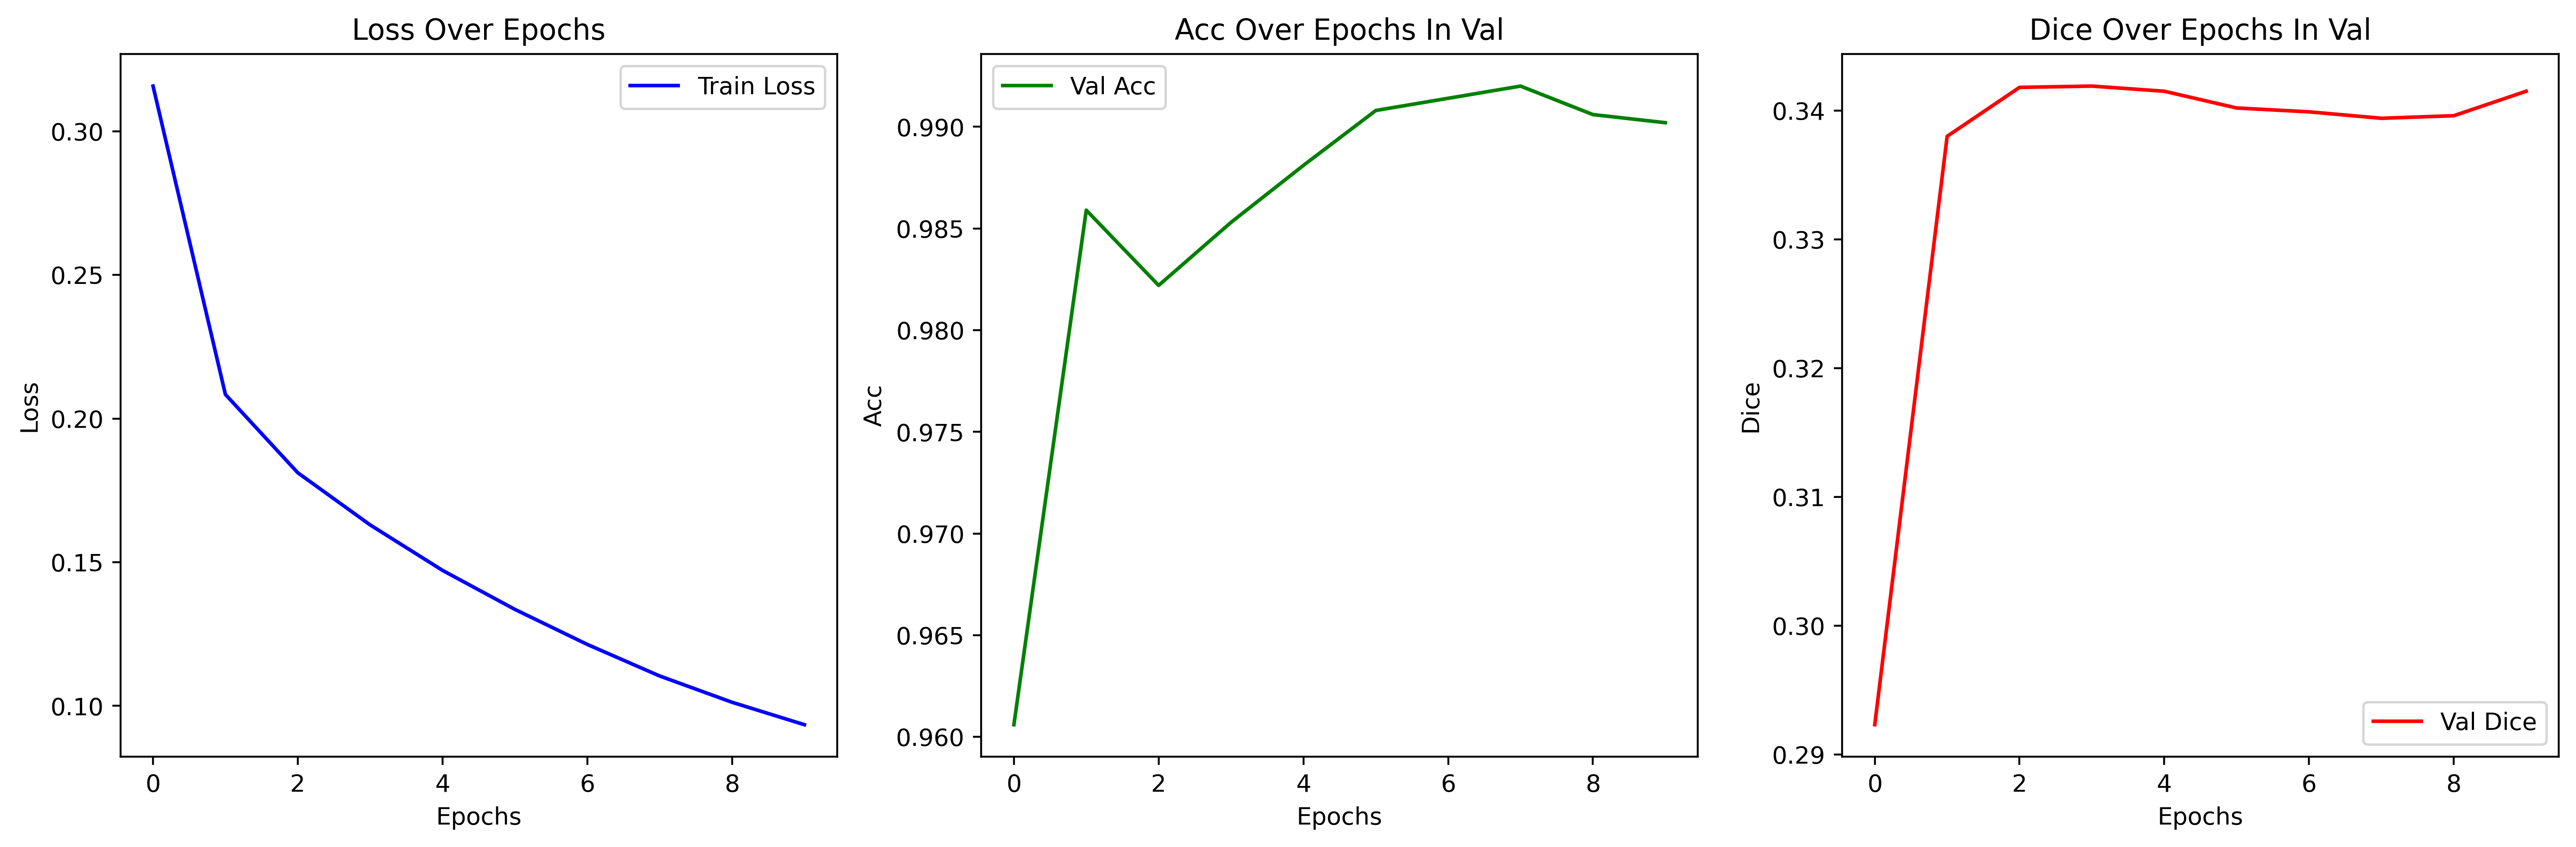

In [33]:
plot_loss_acc(train_loss, val_acc, val_dice, NUM_EPOCH)